In [ ]:
import cv2
import detectron2
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Load the configuration for a pre-trained Mask R-CNN model on COCO dataset
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set confidence threshold
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

# Read the image
image = cv2.imread("path/to/your/image.jpg")

# Run inference
outputs = predictor(image)

# Visualize the results
v = Visualizer(image[:, :, ::-1], MetadataCatalog.get("coco_2017_validation"), scale=1.0)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow("Output", out.get_image()[:, :, ::-1])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
!pip install torch torchvision
!pip install opencv-python
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install mediapipe
!pip install scipy
!pip install scikit-learn

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ayebllkr
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ayebllkr
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=e1a980407e9ccefc1192a3298abf9a022e3ed6ab31b6a2172d9dead308dfd82f
  Stored in directory: /tmp/pip-ephem-wheel-cache-tz5jq0_a/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 47.5 MB/s eta 0:00:00


In [ ]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2024-11-18 22:28:55--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.167.112.51, 3.167.112.129, 3.167.112.53, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.167.112.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   189MB/s    in 16s     

2024-11-18 22:29:11 (151 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


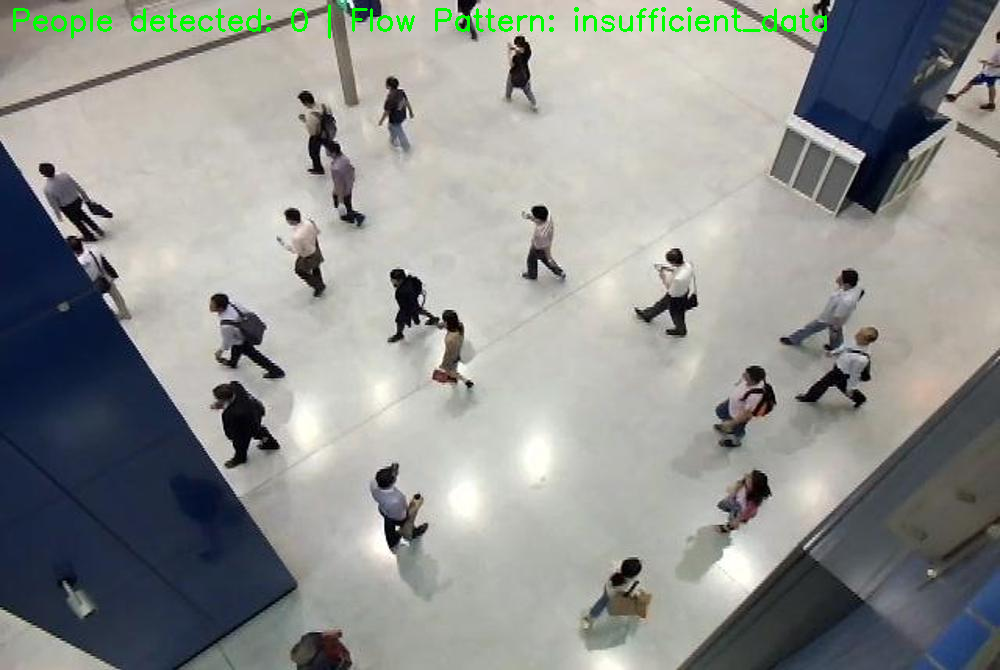

In [ ]:
import numpy as np
import cv2
import torch
from segment_anything import sam_model_registry, SamPredictor
import mediapipe as mp
from scipy.spatial import distance
from google.colab.patches import cv2_imshow
from sklearn.cluster import DBSCAN

class CrowdFlowAnalyzer:
    def __init__(self, sam_checkpoint):
        # Initialize SAM
        self.sam = sam_model_registry["default"](checkpoint=sam_checkpoint)
        self.sam.to("cuda" if torch.cuda.is_available() else "cpu")
        self.predictor = SamPredictor(self.sam)

        # Initialize MediaPipe Pose
        self.mp_pose = mp.solutions.pose
        self.pose = self.mp_pose.Pose(
            static_image_mode=False,
            model_complexity=1,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5
        )

    def detect_people(self, image):
        """Use SAM to detect and segment people in the image"""
        # Convert image to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Set image in SAM predictor
        self.predictor.set_image(image_rgb)

        # Get image dimensions
        height, width = image.shape[:2]

        # Create a grid of points to use as prompts
        y, x = np.mgrid[height//4:3*height//4:height//8, width//4:3*width//4:width//8]
        point_coords = np.stack((x.flatten(), y.flatten()), axis=1)

        # Set point labels (assuming all points are foreground)
        point_labels = np.ones(len(point_coords))

        # Generate masks using point prompts
        masks = []
        for i in range(len(point_coords)):
            mask, scores, logits = self.predictor.predict(
                point_coords=point_coords[i:i+1],
                point_labels=point_labels[i:i+1],
                multimask_output=True
            )

            # Take the mask with highest score
            best_mask = mask[np.argmax(scores)]
            if self._is_person_mask(best_mask):
                masks.append(best_mask)

        # Remove overlapping masks
        final_masks = self._remove_overlapping_masks(masks)

        return final_masks

    def _remove_overlapping_masks(self, masks, iou_threshold=0.5):
        """Remove overlapping masks based on IoU threshold"""
        if not masks:
            return []

        final_masks = []
        masks = sorted(masks, key=lambda x: np.sum(x), reverse=True)  # Sort by area

        for mask in masks:
            should_keep = True
            for final_mask in final_masks:
                intersection = np.logical_and(mask, final_mask)
                union = np.logical_or(mask, final_mask)
                iou = np.sum(intersection) / np.sum(union)

                if iou > iou_threshold:
                    should_keep = False
                    break

            if should_keep:
                final_masks.append(mask)

        return final_masks

    def estimate_poses(self, image, masks):
        """Estimate poses for detected people"""
        poses = []
        for mask in masks:
            # Apply mask to original image
            masked_image = cv2.bitwise_and(image, image, mask=mask.astype(np.uint8))

            # Get pose landmarks
            results = self.pose.process(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
            if results.pose_landmarks:
                poses.append(results.pose_landmarks)

        return poses

    def analyze_flow(self, poses, frame_history=None):
        """Analyze crowd flow patterns"""
        if len(poses) < 2:
            return "insufficient_data"

        # Extract key points (e.g., center of mass) for each person
        positions = []
        for pose in poses:
            # Use hip center as reference point
            hip_center = np.mean([
                [pose.landmark[23].x, pose.landmark[23].y],  # Left hip
                [pose.landmark[24].x, pose.landmark[24].y]   # Right hip
            ], axis=0)
            positions.append(hip_center)

        positions = np.array(positions)

        # Use DBSCAN to identify clusters
        clustering = DBSCAN(eps=0.1, min_samples=2).fit(positions)

        # Analyze spatial distribution
        return self._analyze_spatial_distribution(positions, clustering.labels_)

    def _analyze_spatial_distribution(self, positions, cluster_labels):
        """Analyze spatial distribution of the crowd"""
        n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)

        if n_clusters == 0:
            return "divergent"

        # Calculate centroid
        centroid = np.mean(positions, axis=0)

        # Calculate distances from centroid
        distances = [distance.euclidean(pos, centroid) for pos in positions]

        # Analyze distribution
        mean_dist = np.mean(distances)
        std_dist = np.std(distances)

        if std_dist < 0.1 * mean_dist:
            return "lane"
        elif std_dist > 0.3 * mean_dist:
            return "divergent"
        else:
            return "convergent"

    def _is_person_mask(self, mask):
        """Helper function to identify person masks"""
        # Add criteria for person detection (e.g., size, aspect ratio)
        area = np.sum(mask)
        if area < 1000:  # Minimum area threshold
            return False

        # Calculate aspect ratio
        y, x = np.nonzero(mask)
        if len(y) == 0 or len(x) == 0:
            return False

        height = np.max(y) - np.min(y)
        width = np.max(x) - np.min(x)
        if width == 0:
            return False

        aspect_ratio = height / width

        return 1.5 < aspect_ratio < 4.0  # Typical person aspect ratio range

# Example usage for single image
def main():
    # Initialize analyzer
    analyzer = CrowdFlowAnalyzer("sam_vit_h_4b8939.pth")  # Update path to your checkpoint

    # Read image
    frame = cv2.imread('people1.jpg')
    if frame is None:
        print("Error: Could not read the image 'people.jpg'")
        return

    # Detect people
    masks = analyzer.detect_people(frame)

    # Estimate poses
    poses = analyzer.estimate_poses(frame, masks)

    # Analyze flow
    flow_pattern = analyzer.analyze_flow(poses)

    # Visualize results
    for mask in masks:
        frame = cv2.addWeighted(
            frame,
            1,
            (mask[:, :, None] * [0, 255, 0]).astype(np.uint8),
            0.5,
            0
        )

    # Add text showing number of people detected and flow pattern
    cv2.putText(
        frame,
        f"People detected: {len(masks)} | Flow Pattern: {flow_pattern}",
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (0, 255, 0),
        2
    )

    # Display result
    cv2_imshow(frame)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Save the result
    cv2.imwrite('result.jpg', frame)

if __name__ == "__main__":
    main()